In [19]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light as c
from scipy.special import jn
import time
import os
import set_plot_params
set_plot_params.set_plot_params()
mpl.rcParams['ytick.right'] = False

In [2]:
def dielectric_stack_1D_FC(eps1, eps2, a, eps_ratio, G):
    xi = np.zeros(G.size, dtype = 'complex')
    with np.errstate(divide='ignore', invalid='ignore'):
            xi = np.where(G != 0, 1j/(d1*G)*(1 - np.exp(-1j*G*d1*eps_ratio))*(1/eps2 - 1/eps1), xi)  
    xi[np.where(G == 0)] = eps_ratio*(1/eps1 - 1/eps2) + 1/eps2   

    return xi

def circular_dielectric_rod_2D_FC(eps1, eps2, a, r, G):
    # eps1: dielectric constant of the circular rod 
    # eps2: dielectric constant of the background 
    volume_fraction = np.pi*r**2/a**2
    if np.linalg.norm(G) != 0:
            xi = 2*volume_fraction*(1/eps1 - 1/eps2)*jn(1, np.linalg.norm(G)*r)/(np.linalg.norm(G)*r)
    else:
        xi = volume_fraction*(1/eps1 - 1/eps2) + 1/eps2   

    return xi

def reciprocal_lattice_vectors_2D(d1, d2, theta, N):
    b1 = 2*np.pi/d1*np.array([1, 1/np.tan(theta)])
    b2 = 2*np.pi/(d2*np.sin(theta))*np.array([0, 1])
    G = []
    for h in range(-(N-1), N):
        for k in range(-(N-1), N):
            if abs(h) + abs(k) <= (N-1):
                G.append(h * b1 + k * b2)
    
    return np.array(sorted(G, key=lambda v: np.linalg.norm(v)))

In [ ]:
# set parameters 
eps1 = 1
eps2 = 8
a = 1e-6
eps_ratio = 0.8
zs = np.linspace(0, 20e-6, 400)

Nk = 101
ks = np.linspace(0, np.pi/a, Nk)
N = 70

band_index = 0
k_plot = ks[20]

###############################################################################################################à
G = 2*np.pi/a*np.arange(-N, N+1)

epsilon_z = np.zeros_like(zs)
for i, z in enumerate(zs):
    z_mod = z % a  
    if z_mod < a*eps_ratio:
        epsilon_z[i] = eps1
    else:
        epsilon_z[i] = eps2

theta = np.zeros((2*N+1, 2*N+1), dtype = 'complex')
omegas = np.zeros((Nk, 2*N+1))


for i, k in enumerate(ks): 
    for n in np.arange(0, 2*N+1):
        delta_G = G[n] - G  
        xi = dielectric_stack_1D_FC(eps1, eps2, a, eps_ratio, delta_G)
        theta[n] = xi*(G[n]+k)*(G+k)  
    eigenvalues, eigenvectors = np.linalg.eig(theta)
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    if k == k_plot:
        sorted_eigenvectors_plot = sorted_eigenvectors
    omega = np.sqrt(np.real(sorted_eigenvalues))*c
    omegas[i] = omega

omegas_vacuum = c*ks
omegas_medium = c*ks/np.sqrt((eps_ratio*eps1+(1-eps_ratio)*eps2))

fig, ax = plt.subplots(ncols=2, figsize = (14,4))

normalized_k = k_plot*a/(np.pi)
normalized_ks = ks*a/(np.pi)
normalized_omegas = omegas[:, :4]*a/(2*np.pi*c)
normalized_omegas_vacuum = omegas_vacuum*a/(2*np.pi*c)
normalized_omegas_medium = omegas_medium*a/(2*np.pi*c)

ax[0].plot(normalized_ks, normalized_omegas)
ax[0].plot(normalized_ks, normalized_omegas_vacuum, color = 'black', label = "light line", linestyle = '--', alpha = 0.8)
ax[0].plot(normalized_ks, normalized_omegas_medium, color = 'grey', label = "light line in medium", linestyle = '--', alpha = 0.8)
ax[0].set_ylabel("$fa/c$")
ax[0].set_xlabel(r"$ka/\pi$ ")

Hs = []
for z in zs:
    u = np.sum(sorted_eigenvectors_plot[:, band_index]*np.exp(1j*G*z))
    H = np.exp(1j*k_plot*z)*u
    Hs = np.append(H, Hs)
Es = np.gradient(Hs)/epsilon_z
ax[1].plot(zs*1e6, np.real(Hs), color = 'red')
#ax[1].plot(zs*1e6, np.real(Es), color = 'darkorange')
#ax[1].plot(zs*1e6, epsilon_z)
#ax[1].set_ylabel("$|H|^2$")
ax[1].set_xlabel("$z$ [um]")
for i in range(20):
    ax[1].axvspan(a*i*1e6, (a*i + a*eps_ratio)*1e6, alpha=0.4, color='blue')
    ax[1].axvspan((a*i + a*eps_ratio)*1e6, (a*i + a)*1e6, alpha=0.4, color='green')

ax[0].plot(normalized_k, normalized_omegas[np.where(ks == k_plot), band_index], 'o', color = 'goldenrod', alpha = 0.8)
ax[0].legend()
plt.show()

In [ ]:
diels = []
for z in zs:
    diels = np.append(diels, 1/np.sum(dielectric_stack_1D_FC(eps1, eps2, a, eps_ratio, G)*np.exp(1j*G*z)))
plt.plot(zs*1e6, diels)
plt.plot(zs*1e6, epsilon_z)
#for i in range(10):
    #plt.axvspan(a*i*1e6, (a*i + a*eps_ratio)*1e6, alpha=0.4, color='blue')
    #plt.axvspan((a*i + a*eps_ratio)*1e6, (a*i + a)*1e6, alpha=0.4, color='green')
plt.show()

### 2D BANDSTRUCTURE

Execution time of the for loop: 11.638482 seconds


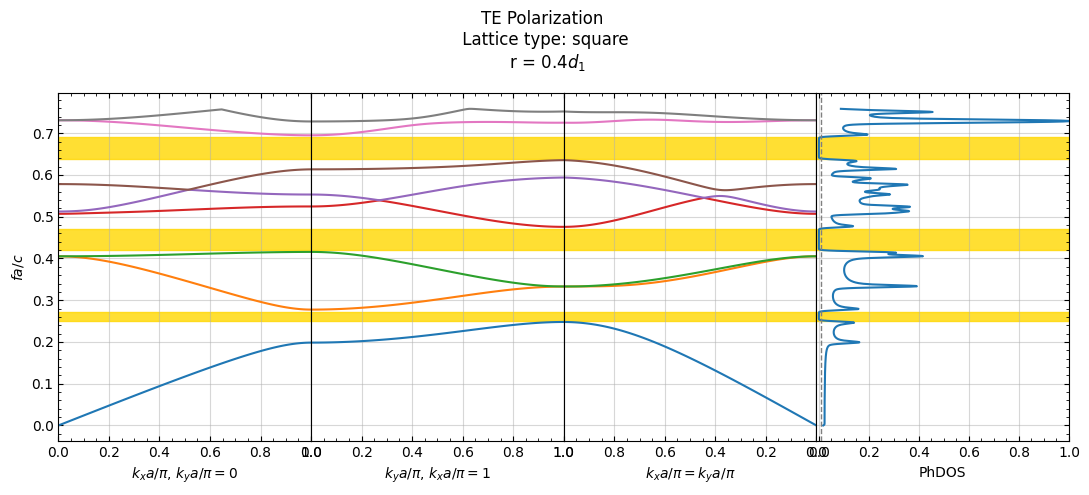

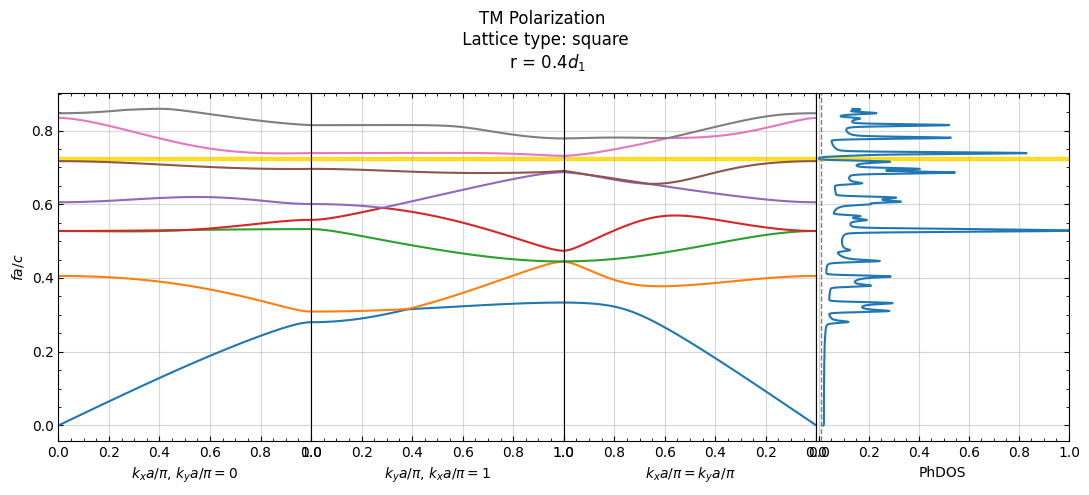

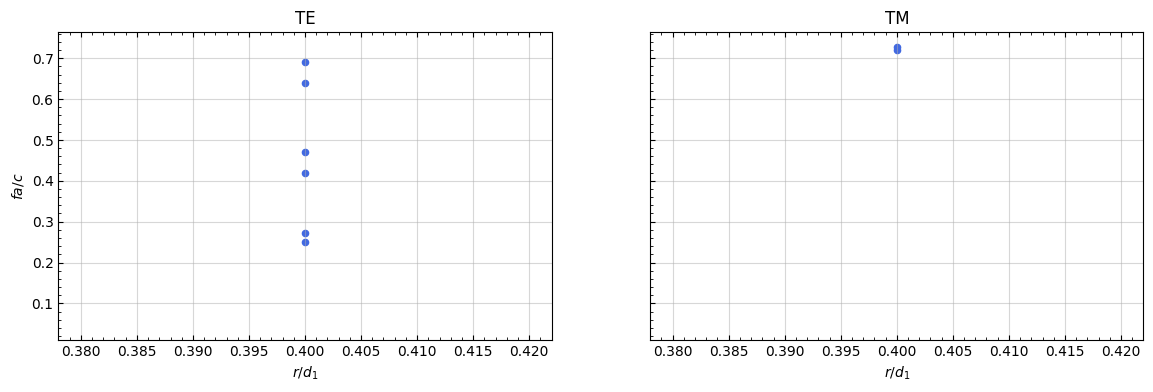

In [20]:
# set parameters 
dielectric_function = 'circular_rods'
eps1 = 9
eps2 = 1
lattice_type = 'square'
if lattice_type == 'oblique':
    d1 = 1e-6
    d2 = d1
    phi = np.pi/4
elif lattice_type == 'rectangular':
    d1 = 1e-6
    d2 = 2e-6
elif lattice_type == 'square':
    d1 = 1e-6
elif lattice_type == 'rhombic':
    d1 = 1e-6
    phi = np.pi/4
elif lattice_type == 'hexagonal':
    d1 = 1e-6
n_rs = 1
rs = d1*np.linspace(0.4, 0.5, n_rs)

Nk = 100
N = 5

threshold = 0.01
show_bands = 8

eta = 0.003
n_omega = 1000

###############################################################################################################
if not os.path.exists(dielectric_function):
    os.makedirs(dielectric_function)


if lattice_type == 'oblique':
    Gs = reciprocal_lattice_vectors_2D(d1, d2, phi, N)
elif lattice_type == 'rectangular':
    phi = np.pi/2
    Gs = reciprocal_lattice_vectors_2D(d1, d2, phi, N)
elif lattice_type == 'square':
    phi = np.pi/2
    Gs = reciprocal_lattice_vectors_2D(d1, d1, phi, N)
    kxs = np.concatenate([np.linspace(0, np.pi/d1, Nk), np.pi/d1*np.ones(Nk), np.linspace(np.pi/d1, 0, Nk)])
    kys = np.concatenate([np.zeros(Nk), np.linspace(0, np.pi/d1, Nk), np.linspace(np.pi/d1, 0, Nk)])
elif lattice_type == 'rhombic':
    Gs = reciprocal_lattice_vectors_2D(d1, d1, phi, N)
elif lattice_type == 'hexagonal':
    phi = 2*np.pi/3
    Gs = reciprocal_lattice_vectors_2D(d1, d1, phi, N)

ks = np.stack((kxs, kys), axis=-1)
Gs_prime = Gs.copy()
dim = int(1+2*N*(N-1))
edges_TE = np.zeros((n_rs,2*(dim-1)))
edges_TM = np.zeros((n_rs,2*(dim-1)))
show_bands = np.min([dim, show_bands])
for i1, r in enumerate(rs):
    start_time = time.perf_counter()
    theta_TE = np.zeros((dim, dim), dtype = 'complex')
    omegas_TE = np.zeros((int(ks.size/2), dim), dtype = 'complex')
    theta_TM = np.zeros((dim, dim), dtype = 'complex')
    omegas_TM = np.zeros((int(ks.size/2), dim), dtype = 'complex')
    for i, k in enumerate(ks): 
        for j1, G in enumerate(Gs):
            G_plus_k = G + k
            for j2, G_prime in enumerate(Gs_prime):
                delta_G = G - G_prime 
                if dielectric_function == 'circular_rods':
                    xi = circular_dielectric_rod_2D_FC(eps1, eps2, d1, r, delta_G)
                theta_TE[j1, j2] = xi*np.linalg.norm(G_prime+k)**2 
                theta_TM[j1, j2] = xi*np.dot(G_plus_k,G_prime+k)  
        eigenvalues_TE, eigenvectors_TE = np.linalg.eig(theta_TE)
        sorted_indices_TE = np.argsort(eigenvalues_TE)
        sorted_eigenvalues_TE = eigenvalues_TE[sorted_indices_TE]
        sorted_eigenvectors_TE = eigenvectors_TE[:, sorted_indices_TE]
        omegas_TE[i] = sorted_eigenvalues_TE

        eigenvalues_TM, eigenvectors_TM = np.linalg.eig(theta_TM)
        sorted_indices_TM = np.argsort(eigenvalues_TM)
        sorted_eigenvalues_TM = eigenvalues_TM[sorted_indices_TM]
        sorted_eigenvectors_TM = eigenvectors_TM[:, sorted_indices_TM]
        omegas_TM[i] = sorted_eigenvalues_TM

    omegas_TE = np.sqrt(np.real(omegas_TE))*c
    omegas_TM = np.sqrt(np.real(omegas_TM))*c
    normalized_ks = ks*d1/(np.pi)
    normalized_omegas_TE = omegas_TE[:, :show_bands]*d1/(2*np.pi*c)
    normalized_omegas_TM = omegas_TM[:, :show_bands]*d1/(2*np.pi*c)

    omega_min_TE = np.min(normalized_omegas_TE)
    omega_max_TE = np.max(normalized_omegas_TE)
    omega_range_TE = np.linspace(omega_min_TE, omega_max_TE, n_omega)
    D_omega_TE = np.zeros_like(omega_range_TE)
    for omega_k_modes_TE in normalized_omegas_TE.T:
        for omega_k_val_TE in omega_k_modes_TE:
            D_omega_TE += 1/(eta*np.sqrt(np.pi))*np.exp(-(omega_range_TE - omega_k_val_TE)**2/eta**2)
    D_omega_TE = D_omega_TE/np.max(D_omega_TE)

    omega_min_TM = np.min(normalized_omegas_TM)
    omega_max_TM = np.max(normalized_omegas_TM)
    omega_range_TM = np.linspace(omega_min_TM, omega_max_TM, n_omega)
    D_omega_TM = np.zeros_like(omega_range_TM)
    for omega_k_modes_TM in normalized_omegas_TM.T:
        for omega_k_val_TM in omega_k_modes_TM:
            D_omega_TM += 1/(eta*np.sqrt(np.pi))*np.exp(-(omega_range_TM - omega_k_val_TM)**2/eta**2)
    D_omega_TM = D_omega_TM/np.max(D_omega_TM)

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Execution time of the for loop: {elapsed_time:.6f} seconds")

    fig, ax = plt.subplots(ncols=4, figsize = (11,5), sharey=True)

    fig.suptitle(f"TE Polarization \n Lattice type: {lattice_type} \n r = ${round(r/d1,2)}d_1$")

    ax[0].plot(normalized_ks[:Nk,0], normalized_omegas_TE[:Nk])
    ax[1].plot(normalized_ks[Nk:2*Nk,1], normalized_omegas_TE[Nk:2*Nk])
    ax[2].plot(normalized_ks[2*Nk:,0], normalized_omegas_TE[2*Nk:])
    ax[0].set_ylabel("$fa/c$")
    ax[0].set_xlabel(r"$k_xa/\pi$, $k_ya/\pi = 0$ ")
    ax[1].set_xlabel(r"$k_ya/\pi$, $k_xa/\pi = 1$")
    ax[2].set_xlabel(r"$k_xa/\pi = k_ya/\pi$ ")
    ax2 = plt.gca()
    ax[2].set_xlim(ax2.get_xlim()[::-1])

    ax[0].set_xlim(0,1)
    ax[1].set_xlim(0,1)
    ax[2].set_xlim(1,0)
    ax[1].tick_params(axis='y', which='both', left=False, right=False)
    ax[2].tick_params(axis='y', which='both', left=False, right=False)
    ax[3].tick_params(axis='y', which='both', left=False, right=False)
    
    ax[3].set_xlim(-0.01,None)
    ax[3].plot(D_omega_TE, omega_range_TE)
    ax[3].axvline(threshold, linestyle = "--", linewidth = 1, color = "grey")
    ax[3].set_xlabel("PhDOS")

    lower_edges = []
    upper_edges = []

    for idx in range(0,D_omega_TE.size-1):
        if (D_omega_TE[idx]>= threshold) and (D_omega_TE[idx+1] <= threshold) :
            lower_edges.append(omega_range_TE[idx])
        if (D_omega_TE[idx] < threshold) and (D_omega_TE[idx+1] >= threshold) :
            upper_edges.append(omega_range_TE[idx])

    for i in range(len(lower_edges)):
        ax[0].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
        ax[1].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
        ax[2].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
        ax[3].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')

    edges_TE[i1][:len(lower_edges) + len(upper_edges)] = np.sort(np.concatenate([lower_edges, upper_edges]))
    
    ax[3].yaxis.tick_right() 
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()

    fig, ax = plt.subplots(ncols=4, figsize = (11,5), sharey=True)

    fig.suptitle(f"TM Polarization \n Lattice type: {lattice_type} \n r = ${round(r/d1,2)}d_1$")

    ax[0].plot(normalized_ks[:Nk,0], normalized_omegas_TM[:Nk])
    ax[1].plot(normalized_ks[Nk:2*Nk,1], normalized_omegas_TM[Nk:2*Nk])
    ax[2].plot(normalized_ks[2*Nk:,0], normalized_omegas_TM[2*Nk:])
    ax[0].set_ylabel("$fa/c$")
    ax[0].set_xlabel(r"$k_xa/\pi$, $k_ya/\pi = 0$ ")
    ax[1].set_xlabel(r"$k_ya/\pi$, $k_xa/\pi = 1$")
    ax[2].set_xlabel(r"$k_xa/\pi = k_ya/\pi$ ")
    ax2 = plt.gca()
    ax[2].set_xlim(ax2.get_xlim()[::-1])

    ax[0].set_xlim(0,1)
    ax[1].set_xlim(0,1)
    ax[2].set_xlim(1,0)
    ax[1].tick_params(axis='y', which='both', left=False, right=False)
    ax[2].tick_params(axis='y', which='both', left=False, right=False)
    ax[3].tick_params(axis='y', which='both', left=False, right=False)
    ax[3].set_xlim(-0.01,None)

    ax[3].plot(D_omega_TM, omega_range_TM)
    ax[3].axvline(threshold, linestyle = "--", linewidth = 1, color = "grey")
    ax[3].set_xlabel("PhDOS")

    lower_edges = []
    upper_edges = []

    for idx in range(0,D_omega_TM.size-1):
        if (D_omega_TM[idx]>= threshold) and (D_omega_TM[idx+1] <= threshold) :
            lower_edges.append(omega_range_TM[idx])
        if (D_omega_TM[idx] < threshold) and (D_omega_TM[idx+1] >= threshold) :
            upper_edges.append(omega_range_TM[idx])

    for i in range(len(lower_edges)):
        ax[0].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
        ax[1].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
        ax[2].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')
        ax[3].axhspan(lower_edges[i], upper_edges[i], alpha=0.8, color='gold')

    edges_TM[i1][:len(lower_edges) + len(upper_edges)] = np.sort(np.concatenate([lower_edges, upper_edges]))
    
    ax[3].yaxis.tick_right() 
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()

fig, ax = plt.subplots(ncols=2, figsize = (14,4), sharey=True)
for i in range(2*(dim-1)):
    ax[0].scatter(rs/d1, edges_TE.T[i], s = 20, color = "royalblue")
    ax[1].scatter(rs/d1, edges_TM.T[i], s = 20, color = "royalblue")
ax[0].set_ylim(0.01, None)
ax[1].set_ylim(0.01, None)
ax[0].set_xlabel("$r/d_1$")
ax[1].set_xlabel("$r/d_1$")
ax[0].set_ylabel("$fa/c$")
ax[0].set_title("TE")
ax[1].set_title("TM")
plt.savefig(f"{lattice_type}_bandstructure_map_eps_rod{eps1}_eps_back{eps2}")
plt.show()

In [ ]:
def create_oblique_lattice(a, b, theta):
    a1 = np.array([a, 0])
    a2 = np.array([b * np.cos(np.radians(theta)), b * np.sin(np.radians(theta))])
    return a1, a2

def plot_lattice(a1, a2, title, ax, lattice_color='b', lattice_alpha=0.8, arrow_color='k'):
    # Draw the direct lattice points
    for i in range(-2, 3):
        for j in range(-2, 3):
            point = i * a1 + j * a2
            ax.plot(point[0], point[1], 'o', color=lattice_color, alpha=lattice_alpha)
    # Draw the lattice vectors
    ax.quiver(0, 0, a1[0], a1[1], angles='xy', scale_units='xy', scale=1, color=arrow_color, alpha=lattice_alpha, width=0.01)
    ax.quiver(0, 0, a2[0], a2[1], angles='xy', scale_units='xy', scale=1, color=arrow_color, alpha=lattice_alpha, width=0.01)
    ax.set_title(title, fontsize=12)
    ax.set_aspect('equal')
    ax.grid(True, which='both', linestyle='--', alpha=0.7)

def reciprocal_lattice(a1, a2):
    area = np.cross(a1, a2)
    b1 = 2 * np.pi * np.array([a2[1], -a2[0]]) / area
    b2 = 2 * np.pi * np.array([-a1[1], a1[0]]) / area
    return b1, b2

def set_dynamic_limits(ax, a1, a2):
    # Compute limits based on lattice vectors
    x_max = max(abs(a1[0]), abs(a2[0])) * 3 + 0.8
    y_max = max(abs(a1[1]), abs(a2[1])) * 3 + 0.8
    ax.set_xlim(-x_max, x_max)
    ax.set_ylim(-y_max, y_max)

# Define lattice vectors for different types of lattices
lattices = {
    "Oblique": (1.5, 1.0, 75),
    "Rectangular": (1.5, 1.0, 90),
    "Centered Rectangular": (2.0, 2.0, 60),
    "Square": (1.0, 1.0, 90),
    "Hexagonal": (1.0, 1.0, 120)
}

fig, axs = plt.subplots(len(lattices), 2, figsize=(14, 14), constrained_layout=True)

# Use different colors for each lattice type
colors = plt.cm.tab10.colors[:len(lattices)]

for i, (name, (a, b, theta)) in enumerate(lattices.items()):
    a1, a2 = create_oblique_lattice(a, b, theta)
    b1, b2 = reciprocal_lattice(a1, a2)
    
    # Plot real lattice (lighter color)
    plot_lattice(a1, a2, f"{name} Lattice", axs[i, 0], lattice_color=colors[i], arrow_color='k')
    set_dynamic_limits(axs[i, 0], a1, a2)
    
    # Plot reciprocal lattice (darker color)
    plot_lattice(b1, b2, f"{name} Reciprocal Lattice", axs[i, 1], lattice_color=colors[i], lattice_alpha=0.7, arrow_color='k')
    set_dynamic_limits(axs[i, 1], b1, b2)

plt.show()